## Audio data

Here are some key concepts and features of audio data. As an audio signal is the vibration generated when sound passes through air. For audio, when sound is captured from a microphone, it's an analog form. The analog sound is converted to digital sound format by sampling at consistent intervals of time. The number of audio data points recorded every second is called the `sample rate`.
* The higher sample rate, the higher the quality of the sound. However, after a certain point, the human ear can't detect the difference.
* The average sound sample rate is 48 kilohertz(KHz) or 48,000 samples per second. The dataset we'll be using in this module was sampled at 16KHz, so our sample rate is 16,000 samples per second.

When the audio is sampled, the **frequency** of the sound is the number of times per second that a sound wave repeats itself. The `amplitude` is how loud the audio is. we can take our sample rate and frequency, and represent the signal visually. This visual signal can be represented as a `waveform`, which is the signal representation over time in a graphical format. The audio can be recorded in different channel. For example, stereo recordings have two channels, right and left.

Now let's take a moment to understand how we might want to parse out a file. For example, if you have longer audio files, you might want to split it out into frames, or sections, of the audio to be classified indivisually. For this dataset, we don't need to set any frames of our audio samples, because each sample is only one second and one word. Another processing step might be an offset, which means the number of frames from the start of the file to befin data loading.

## Get set up with TorchAudio

TorchAudio is a library that is part of the PyTorch ecosystem. It has I/O functionality, popular open datasets, and common audio transformations that we'll need to build our model. We will use this library to work weith our audio data.

In [1]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import torchaudio
import IPython.display as ipd
import matplotlib.pyplot as plt

We will use the speech commands sample dataset, and download the full dataset in a local directory. Note that we're only using `yes` or `no` classes to create a binary classification model.

In [3]:
!wget -P ./data/SpeechCommands/speech_commands_v0.02/ http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz

--2023-07-26 11:58:23--  http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.99.128, 2607:f8b0:400e:c0c::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.99.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2428923189 (2.3G) [application/gzip]
Saving to: ‘./data/SpeechCommands/speech_commands_v0.02/speech_commands_v0.02.tar.gz’

speech_commands_v0. 100%[===================>]   2.26G   198MB/s    in 12s     

2023-07-26 11:58:35 (193 MB/s) - ‘./data/SpeechCommands/speech_commands_v0.02/speech_commands_v0.02.tar.gz’ saved [2428923189/2428923189]



In [4]:
!tar -xzf ./data/SpeechCommands/speech_commands_v0.02/speech_commands_v0.02.tar.gz -C ./data/SpeechCommands/speech_commands_v0.02/

In [5]:
#  the dataset is no longer publicly availabl, so we set download as true and download data manually
trainset = torchaudio.datasets.SPEECHCOMMANDS(f'./data/', download=False)

### Visualize the classes available in the dataset

There are 36 audio classes in the speech commands dataset, each sampled at 16 KHZ, Let's print the different commands avaliable. The two classes we'll be using are `yes` and `no` commands.

In [6]:
default_dir='/kaggle/working'

In [7]:
os.chdir(f'./data/SpeechCommands/speech_commands_v0.02')

labels = [name for name in os.listdir('.') if os.path.isdir(name)]
# back to default directory
os.chdir(default_dir)
print(f'Total Lables: {len(labels)}\n')
print(f'Labels: {labels}')

Total Lables: 36

Labels: ['off', 'yes', 'five', 'wow', '_background_noise_', 'eight', 'stop', 'sheila', 'backward', 'marvin', 'nine', 'seven', 'follow', 'no', 'cat', 'bed', 'four', 'happy', 'forward', 'right', 'one', 'dog', 'two', 'visual', 'house', 'six', 'learn', 'go', 'three', 'up', 'on', 'left', 'bird', 'down', 'tree', 'zero']


### Conver the sound to tensor

You likely have used a wave file before. It's one format in which we save our digital representaion of our analog audio to be shared and played. The speech commands dataset that we will be using in this tutorial is stored in wave files that are all one second or less.

Let's load up one of the wave files and take a look at how the tensors for the `waveform` look. We're loading the files by using `torchaudio.load`, which loads an audio file into a `torch.Tensor` object. TorchAudio takes care of the implmentation, so you don't need to worry about it. The `torch.load` function returns the waveform as a tensor, and an `int` of the `sample_rate`.

In [8]:
file_name = './data/SpeechCommands/speech_commands_v0.02/yes/00f0204f_nohash_0.wav'
waveform, sample_rate = torchaudio.load(file_name,num_frames=3)
print(f'waveform tensor with 3 frames: {waveform}\n')
waveform, sample_rate = torchaudio.load(file_name, num_frames=3, frame_offset=2)
print(f'waveform tensor with 2 frames offset: {waveform}\n')
waveform, sample_rate = torchaudio.load(file_name)
print(f'waveform tensor with all frames: {waveform}')

waveform tensor with 3 frames: tensor([[0.0005, 0.0007, 0.0005]])

waveform tensor with 2 frames offset: tensor([[0.0005, 0.0004, 0.0007]])

waveform tensor with all frames: tensor([[0.0005, 0.0007, 0.0005,  ..., 0.0008, 0.0008, 0.0007]])


## Plot the waveform

Next, create a `plot_audio` function to display the waveform, and listen to a sample of each class.

In [9]:
def plot_audio(filename):
    waveform, sample_rate = torchaudio.load(filename)
    print("Shape of waveform: {}".format(waveform.size()))
    print("Sample rate of waveform: {}".format(sample_rate))

    plt.figure()
    plt.plot(waveform.t().numpy())

    return waveform, sample_rate

The size of the audio is 1x16000. This means that it's 1 second long, at a sample rate of 16000. We can see the graphical waveform of the sound captured, and play the audio for the `yes` command.

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


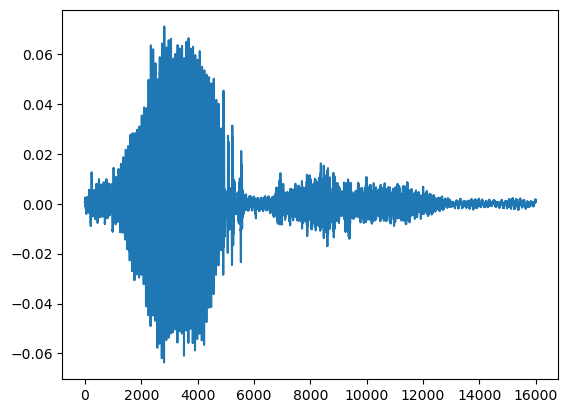

In [10]:
filename = './data/SpeechCommands/speech_commands_v0.02/yes/00f0204f_nohash_0.wav'
waveform, sample_rate = plot_audio(filename)
ipd.Audio(waveform.numpy(), rate=sample_rate)

Next, let's look at the waveform and audio for the `no` command. As you can see, the waveform differs from the sound pattern for the `yes` command. 

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


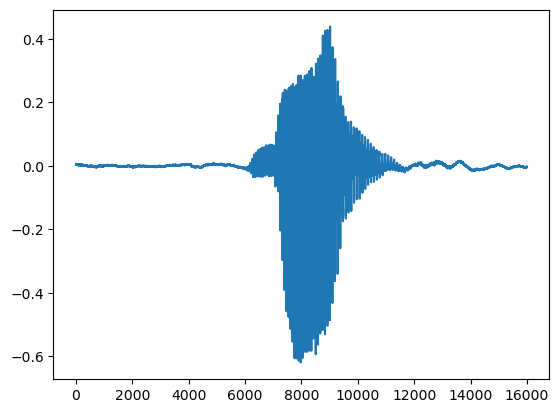

In [11]:
filename = './data/SpeechCommands/speech_commands_v0.02/no/0b40aa8e_nohash_0.wav'
waveform, sample_rate = plot_audio(filename)
ipd.Audio(waveform.numpy(), rate=sample_rate)